# Adjoint Method with FDTD Solver Meep

## Summary of the adjoint method

Inverse design of the frequency space problems of the Maxwell's equations can be formulated as
\begin{align}
\frac{d f }{d \mathbf{p}} = \frac{\partial f }{\partial \mathbf{p}} - \vec{\lambda}^{T} \left(A_{\mathbf{p}}\mathbf{x} - b_\mathbf{p}\right).
\end{align}
with the forward simulation 
\begin{align}
A\mathbf{x} = \mathbf{b}
\end{align}
and the adjoint (backward) simulation 
\begin{align}
A^{T} \vec{\lambda} = f_{\mathbf{x}}^{T}.
\end{align}
If there is reciprocity (as in the Maxwell's equations), $A = A^{T}$, and
\begin{align}
A \vec{\lambda} = f_{\mathbf{x}}^{T}.
\end{align}

## FDTD and Meep

In the frequency-domain electromagnetism problems, 

\begin{align}
A = \nabla \times (\nabla\times) + \epsilon(\mathbf{r}) \frac{\omega^2}{c^2}. 
\end{align}
If one chooses $\epsilon(\mathbf{r})$ as the design parameter $\mathbf{p}$, the method is referred to as density-based topology optimization in the literature. The gradient is 
\begin{align}
\frac{d f}{ d \mathbf{p}} = - 2\frac{\omega^2}{c^2} \mathrm{Re} \left[
\sum_{\mathbf{r}_j\in \mathcal{V}}\vec{\lambda}^{T}(\mathbf{r}_j) \mathbf{E}(\mathbf{r}_j) \right], 
\end{align}

where $\mathcal{V}$ is the design region. 
Meep, a finite difference time-domain method, can solve both the forward and adjoint simulation in the time-domain, which means that the results cover a frequency ranges. One can simply do the fourier transform to obtain the frequency-domain result from the Meep's output $\mathbf{E}(t)$ and 
$\vec{\lambda}(t)$. In Meep, the source term $\mathbf{b}$ is not directly a current density $\mathbf{J}$, but a time-varying electric filed $\mathbf{E}_{\mathrm{in}}$.
```
sources = [mp.Source(mp.ContinuousSource(frequency=0.15),
                component=mp.Ez,
                center=mp.Vector3(-7,0))]
```

## Outline of the Codes


1. Package `meep` does the FDTD simulation. 
2. Package `meep.adjoint` computes the gradient $\frac{df}{d\mathbf{p}}$ by doing both the forward and adjoint runs. Somehow, the core codes are written in C and wrapped up to python with SWIG. Thus, one can not modify the codes in the python level, but has to go the the C interface. 
3. Package `autograd` is used to compute the adjoint source $f_{\mathbf{E}}$. 
(Automatic differentiation is an important method to valuate the partial derivative of a function given by a code. It takes the advantages of the chain rules.)
4. Package `nlopt` is used to update the new parameter $\mathbf{p}$. `nlopt` is a collection of many nonlinear algorithm. Here, we use the gradient-based method *MMA* and *BFGS* to do 
\begin{align}
\mathbf{p}^{(k+1)} = \mathbf{p}^{(k)} + \Delta \mathbf{p}.  
\end{align}

Reference: Meep Team provides a series of tutorials of jupyter notebooks and python files at 
https://github.com/NanoComp/meep/tree/master/python/examples/adjoint_optimization


## 90 degree bend 

This notebook is modified from https://github.com/NanoComp/meep/tree/master/python/examples/

In [1]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
import nlopt
from matplotlib import pyplot as plt
from meep import Animate2D
from autograd import tensor_jacobian_product
from matplotlib.patches import Circle

mp.verbosity(0)
Si = mp.Medium(index=3.4)
SiO2 = mp.Medium(index=1.44)

In [2]:
## geometry
resolution = 10  # pixels/um
sx = 12  # size of cell in X direction
sy = 12  # size of cell in Y direction
cell = mp.Vector3(sx, sy, 0)
dpml = 1.0
pml_layers = [mp.PML(dpml)]

w = 1.5
y_loc = -3

design_region_width = 3
design_region_height = 3
design_region_resolution = 10
design_region_resolution = int(1 * resolution)
Nx = int(design_region_resolution * design_region_width) + 1
Ny = int(design_region_resolution * design_region_height) + 1

design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny), SiO2, Si, grid_type="U_MEAN")
design_region = mpa.DesignRegion(
    design_variables, volume=mp.Volume(center=mp.Vector3(w/2,y_loc), size=mp.Vector3(design_region_width, design_region_height))
)


geometry = [
    mp.Block(
        mp.Vector3(sx/2 , w),
        center = mp.Vector3(-sx/4, y_loc),
        material = Si,
    ),
    mp.Block(
        mp.Vector3(w, sy/2 - y_loc + w /2),
        center=mp.Vector3( w/2, sy/4 + y_loc/2 - w/4),
        material = Si,
    ),
     mp.Block(
        center=design_region.center, size=design_region.size, material=design_variables
    ),  # design region
]

## source 
fcen = 0.15
width = 0.1
fwidth = width * fcen
source_center = [- 4, y_loc, 0]
source_size = mp.Vector3(0, 2 * w, 0)
kpoint = mp.Vector3(1, 0, 0)
src = mp.GaussianSource(frequency=fcen, fwidth=fwidth)
source = [
    mp.EigenModeSource(
        src,
        eig_band=1,
        direction=mp.NO_DIRECTION,
        eig_kpoint=kpoint,
        size=source_size,
        center=source_center,
    )
]

##
sim = mp.Simulation(
    cell_size=cell,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    eps_averaging=False,
    resolution=resolution,
)

##

TE_top = mpa.EigenmodeCoefficient(
    sim, mp.Volume(center=mp.Vector3(w/2, 6.5 + y_loc, 0), size=mp.Vector3(x=2*w)), mode=1
)

TE0 = mpa.EigenmodeCoefficient(
    sim, mp.Volume(center=mp.Vector3(-3, y_loc, 0), size=mp.Vector3(y=2*w)), mode=1
)

ob_list = [TE0, TE_top]


def J(source, top):
    return npa.abs(top / source) ** 2




opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=J,
    objective_arguments=ob_list,
    design_regions=[design_region],
    fcen=fcen,
    df=0,
    nf=1,
)

In [3]:
minimum_length = 0.09  # minimum length scale (microns)
eta_i = (
    0.5  # blueprint (or intermediate) design field thresholding point (between 0 and 1)
)
eta_e = 0.55  # erosion design field thresholding point (between 0 and 1)
eta_d = 1 - eta_e  # dilation design field thresholding point (between 0 and 1)
filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length, eta_e)
print(filter_radius)
print(resolution)


0.20124611797498096
10


### Conic filter
\begin{align}
w(x, y) = \frac{1}{N_w}\begin{cases} 0,& \text{if } r(x, y) > R \\  1 - \frac{r}{R}, & \text{if } r \leq R \end{cases} 
\end{align}

where the constant $N_w$ ensures $\sum w(x_i,y_i) =1$. After a step of optimization, the new $\epsilon(x,y)$ might contains feature sizes smaller than wanted. 
The conic filter is used to smoothern the features by doing convulotion
\begin{align}
\epsilon_\mathrm{filtered}(x, y) = \sum_{i} w(x-x_i,y-y_i) \epsilon(x_i,y_i).
\end{align}


Ref: B.S. Lazarov, F. Wang, & O. Sigmund, Length scale and
manufacturability in density-based topology optimization.
Archive of Applied Mechanics, 86(1-2), pp. 189-218 (2016).

### Tanh Projection
$$
\frac{{\tanh(\beta \eta) + \tanh(\beta (x - \eta))}}{{\tanh(\beta \eta) + \tanh(\beta (1 - \eta))}} 
$$
 Ref: F. Wang, B. S. Lazarov, & O. Sigmund, On projection methods, convergence and robust formulations in topology optimization. Structural and Multidisciplinary Optimization, 43(6), pp. 767-784 (2011).

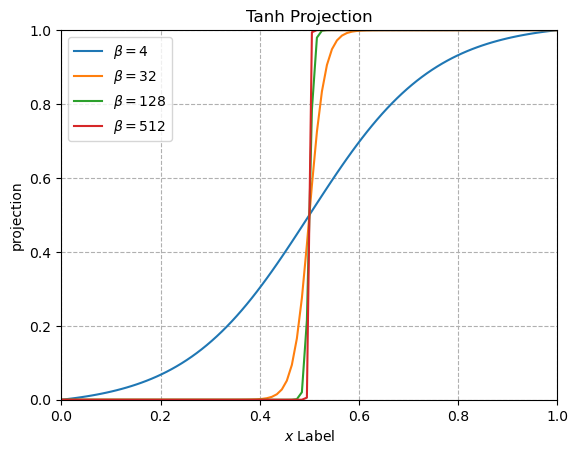

In [4]:
## plot tanh projection for eta = 0.5 beta = 4, 32, 128, 512
def tanh_p(x,beta,eta):
    nume = np.tanh(beta*eta) + np.tanh(beta*(x-eta))
    deno = np.tanh(beta*eta) + np.tanh(beta*(1-eta))
    return nume / deno
x =np.linspace(0,1,100)
plt.figure()
plt.plot(x, tanh_p(x,4,0.5),label =r'$\beta=4 $')
plt.plot(x, tanh_p(x,32,0.5),label =r'$\beta=32 $')
plt.plot(x, tanh_p(x,128,0.5),label =r'$\beta=128 $')
plt.plot(x, tanh_p(x,512,0.5),label =r'$\beta=512 $')
# Add title and labels
plt.title('Tanh Projection')
plt.xlabel('$x$ Label')
plt.ylabel('projection')
# Display grid
plt.grid(True,linestyle='dashed')
#
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend()
plt.show()

In [5]:
def mapping(x, eta, beta):

    # filter
    filtered_field = mpa.conic_filter(
        x,
        filter_radius,
        design_region_width,
        design_region_height,
        design_region_resolution,
    )

    # projection
    projected_field = mpa.tanh_projection(filtered_field, beta, eta)

    projected_field = (
        npa.rot90(projected_field.T, 2) + projected_field
    ) / 2  # 90-degree symmetry

    # interpolate to actual materials
    return projected_field.flatten()

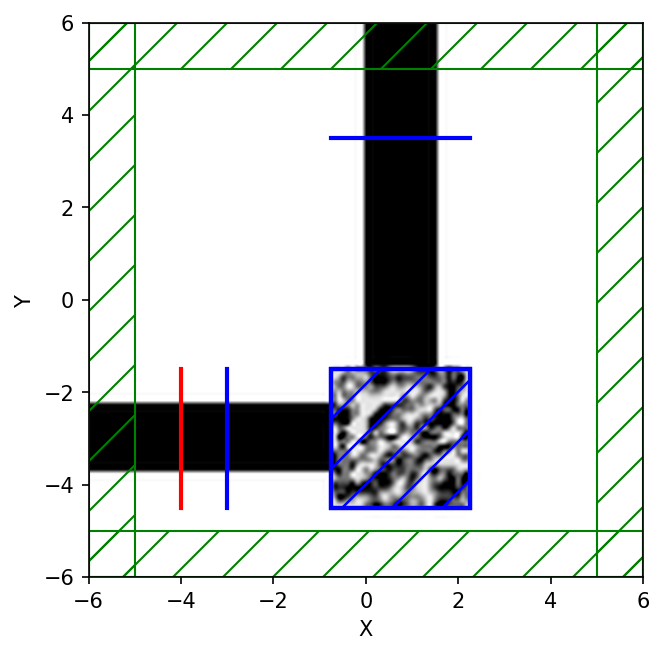

In [6]:
%matplotlib inline
plt.figure(dpi=150)
rho_vector = np.random.rand(Nx * Ny)
opt.update_design([mapping(rho_vector, eta_i, 1e3)])
opt.plot2D(True, output_plane=mp.Volume(center=(0, 0, 0), size=(sx, sy, 0)))

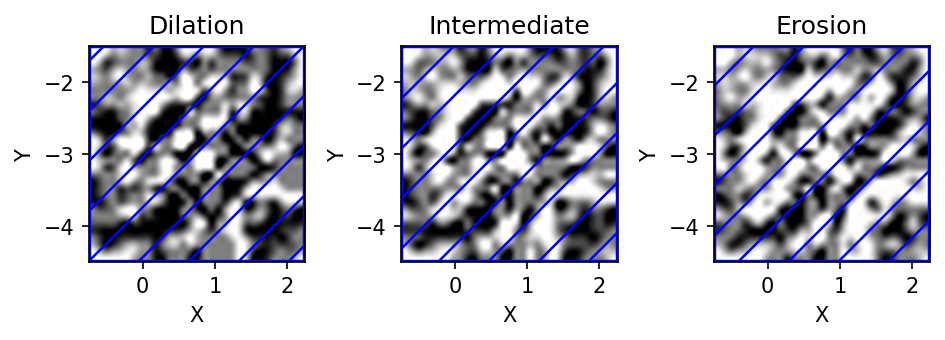

In [9]:
%matplotlib inline
beta = 2048

fig, (ax1, ax2, ax3) = plt.subplots(1, 3,dpi=150)
opt.update_design([mapping(rho_vector, 0.48, beta)])
opt.plot2D(True, ax=ax1, output_plane=mp.Volume(center=(0.75, y_loc, 0), size=(sx/4,sy/4, 0)))
ax1.set_title("Dilation")

opt.update_design([mapping(rho_vector, 0.5, beta)])
opt.plot2D(True, ax=ax2, output_plane=mp.Volume(center=(0.75, y_loc, 0), size=(sx/4, sy/4, 0)))
ax2.set_title("Intermediate")

opt.update_design([mapping(rho_vector, 0.52, beta)])
opt.plot2D(True, ax=ax3, output_plane=mp.Volume(center=(0.75, y_loc, 0), size=(sx/4, sy/4, 0)))
ax3.set_title("Erosion")

fig.tight_layout()

In [8]:
evaluation_history = []
cur_iter = [0]


def f(v, gradient, cur_beta):
    print("Current iteration: {}".format(cur_iter[0] + 1))

    f0, dJ_du = opt([mapping(v, eta_i, cur_beta)])  # compute objective and gradient
    f0 = f0[0] # !!! convert length-1 array to float. do not ignore this step. Or a bit subtle to find this bug. 
    if gradient.size > 0:
        gradient[:] = tensor_jacobian_product(mapping, 0)(
            v, eta_i, cur_beta, dJ_du
        )  # backprop

    evaluation_history.append(np.real(f0))

    cur_iter[0] = cur_iter[0] + 1
    return np.real(f0)

Current iteration: 1
Starting forward run...


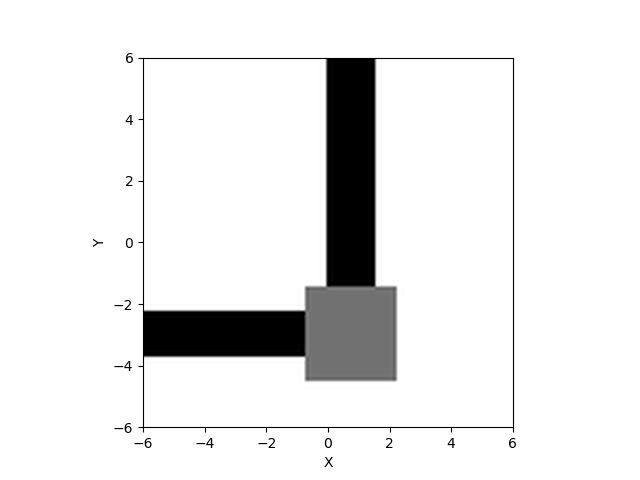

Starting adjoint run...
Calculating gradient...
Current iteration: 2
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current iteration: 3
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current iteration: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current iteration: 5
Starting forward run...


/home/jwu/anaconda/envs/mp24/lib/python3.11/site-packages/meep/geom.py:588: UserWarning: The weights parameter of MaterialGrid must be in the range [0,1].
  warnings.warn(


Starting adjoint run...


In [ ]:
%matplotlib ipympl

# Create the animation
animate = Animate2D(
    fields=None,
    realtime=True,
    eps_parameters={'contour': False, 'alpha': 1, 'frequency': 0.15},
    plot_sources_flag=False,
    plot_monitors_flag=False,
    plot_boundaries_flag=False,
    update_epsilon=True,  # required for the geometry to update dynamically
    nb=True         # required if running in a Jupyter notebook
)
# This will trigger the animation at the end of each simulation
opt.step_funcs=[mp.at_end(animate)]

algorithm = nlopt.LD_MMA
n = Nx * Ny  # number of parameters

# Initial guess
x = np.ones((n,)) * 0.5

# lower and upper bounds
lb = np.zeros((Nx * Ny,))
ub = np.ones((Nx * Ny,))

cur_beta = 4
beta_scale = 2
num_betas = 6
update_factor = 12
for iters in range(num_betas):
    solver = nlopt.opt(algorithm, n)
    solver.set_lower_bounds(lb)
    solver.set_upper_bounds(ub)
    solver.set_max_objective(lambda a, g: f(a, g, cur_beta))
    solver.set_maxeval(update_factor)
    x[:] = solver.optimize(x)
    cur_beta = cur_beta * beta_scale
    print("Current ite_beta: {}".format(iters + 1))
    print("Current beta: {}".format(cur_beta))

The animation can be embedded in the notebook using the 'to_jshtml' method:

In [ ]:
animate.to_jshtml(fps=5)

In [ ]:
plt.figure()
plt.plot(evaluation_history, ".-")
plt.grid()
plt.yticks(np.arange(0, 1, 0.1))
plt.xlabel("Iteration")
plt.ylabel("Transmission")
plt.plot([0,72],[np.max(evaluation_history),np.max(evaluation_history)])
plt.xlim([0,72])
plt.show()
print('Final transmission =', evaluation_history[-1] )

In [ ]:
plt.figure()
eps_design = np.rot90(x.reshape(Nx,Ny))
plt.imshow(eps_design,cmap='binary')
plt.clim([0,1])
plt.colorbar()
plt.contour(eps_design,linewidths=2,cmap='rainbow',levels=np.linspace(0,1,10),linestyles='dashed')
plt.colorbar()
plt.show()

In [ ]:
## update the epsilon weight with the optimized x
design_variables.update_weights(x)
##
geometry = [
    mp.Block(
        mp.Vector3(sx/2 , w),
        center = mp.Vector3(-sx/4, y_loc),
        material = Si,
    ),
    mp.Block(
        mp.Vector3(w, sy/2 - y_loc + w /2),
        center=mp.Vector3( w/2, sy/4 + y_loc/2 - w/4),
        material = Si,
    ),
     mp.Block(
        center=design_region.center, size=design_region.size, material=design_variables
    ),  # design region
]

##
## source 
src = [
    mp.Source(
        mp.ContinuousSource(frequency=fcen),
        component=mp.Ez,
        center=mp.Vector3(-sx/2 +  1 * dpml, y_loc, 0),
        size=mp.Vector3(0, 2 * w, 0),
    )
]

##
sim_opt = mp.Simulation(
    cell_size=cell,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=src,
    eps_averaging=False,
    resolution=resolution,
)
##
plt.figure()
sim_opt.plot2D()
plt.show()

In [ ]:
## animation
from IPython.display import Video
import mycmapls as ms# colormap defined in mycmapls.py

f = plt.figure(dpi=100)
Animate = mp.Animate2D(fields=mp.Ez, f=f, realtime=False, normalize=True
                      , field_parameters={'alpha':1,'cmap':ms.bifan})
plt.close()
sim_opt.run(mp.at_every(0.5, Animate), until=300)
plt.close()
filename = "bend_waveguide_id.mp4"
Animate.to_mp4(10, filename)
Video(filename)